## Kernel Eigenfaces

In [214]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import os
from PIL import Image

### PCA and LDA Eigenfaces and Fisherfaces

### Part I
### PCA eigenfaces

First, try to use PCA to find the first 25 eigenfaces. To find the eigenvalues and eigenvectors of PCA analysis, we should compute the covariance matrix of the data first. And after obtaining the eigenvalues we can sort the value from the largest to the smallest.

In [4]:
## read file and also the label of the file to classify different person's face.
def read_file(dir , H , W):
    file_path = os.listdir(dir)
    images = np.zeros((H*W, len(file_path)))
    labels = np.zeros(len(file_path) , dtype = int)
    for i,name in enumerate(file_path):
        image_dir = os.path.join(dir , name)
        images[:,i] = np.array(Image.open(image_dir).resize((W , H) , Image.Resampling.LANCZOS)).flatten()
        labels[i] = int(name.split('.')[0][7:9]) - 1
    
    return images , labels

In [5]:
## compute PCA
def PCA(data):
    x_mean = data.mean(axis = 1)
    data_center = data - x_mean.reshape(-1,1)

    eigenvalue , eigenvector = np.linalg.eig(data_center.T@data_center)

    ## sort the eigenvalue from largest to smallest
    sort_idx = np.argsort(eigenvalue)[::-1]
    eigenvalue = eigenvalue[sort_idx]

    ## transform the data by projecting it onto the space of N eigenfaces
    eigenvector = data_center@eigenvector[:,sort_idx]
    norm = np.linalg.norm(eigenvector , axis = 0)
    eigenvector = eigenvector / norm
    
    return eigenvalue , eigenvector , x_mean.reshape(-1,1)

In [6]:
## show eigenfaces from top N eigenvectors
def show_eigenface(vec , num , H , W):
    vec = vec[:,:num].reshape(H , W , -1)
    row , col = num//5 , 5

    figure , axis = plt.subplots(row , col , figsize = (15,15))

    for i in range(row):
        for j in range(col):
            axis[i ,j].imshow(vec[:,:,j+i*5] , cmap = "gray")

## show reconstructed faces
def reconstructed_faces(x_train , vec , num , H , W):
    pick = np.random.randint(low = 0 , high = vec.shape[1] , size = num)
    recon_image = vec[:,pick].reshape(H , W , -1)
    origin_image = x_train[:,pick].reshape(H , W , -1)

    row , col = num//5 , 5
    figure , axis = plt.subplots(row , col , figsize = (15,5))
    figure_2 , axis_2 = plt.subplots(row , col , figsize = (15,5))

    for i in range(row):
        for j in range(col):
            axis[i , j].imshow(recon_image[:,:,j+i*5] , cmap = "gray")
            axis_2[i , j].imshow(origin_image[:,:,j+i*5] , cmap = "gray")



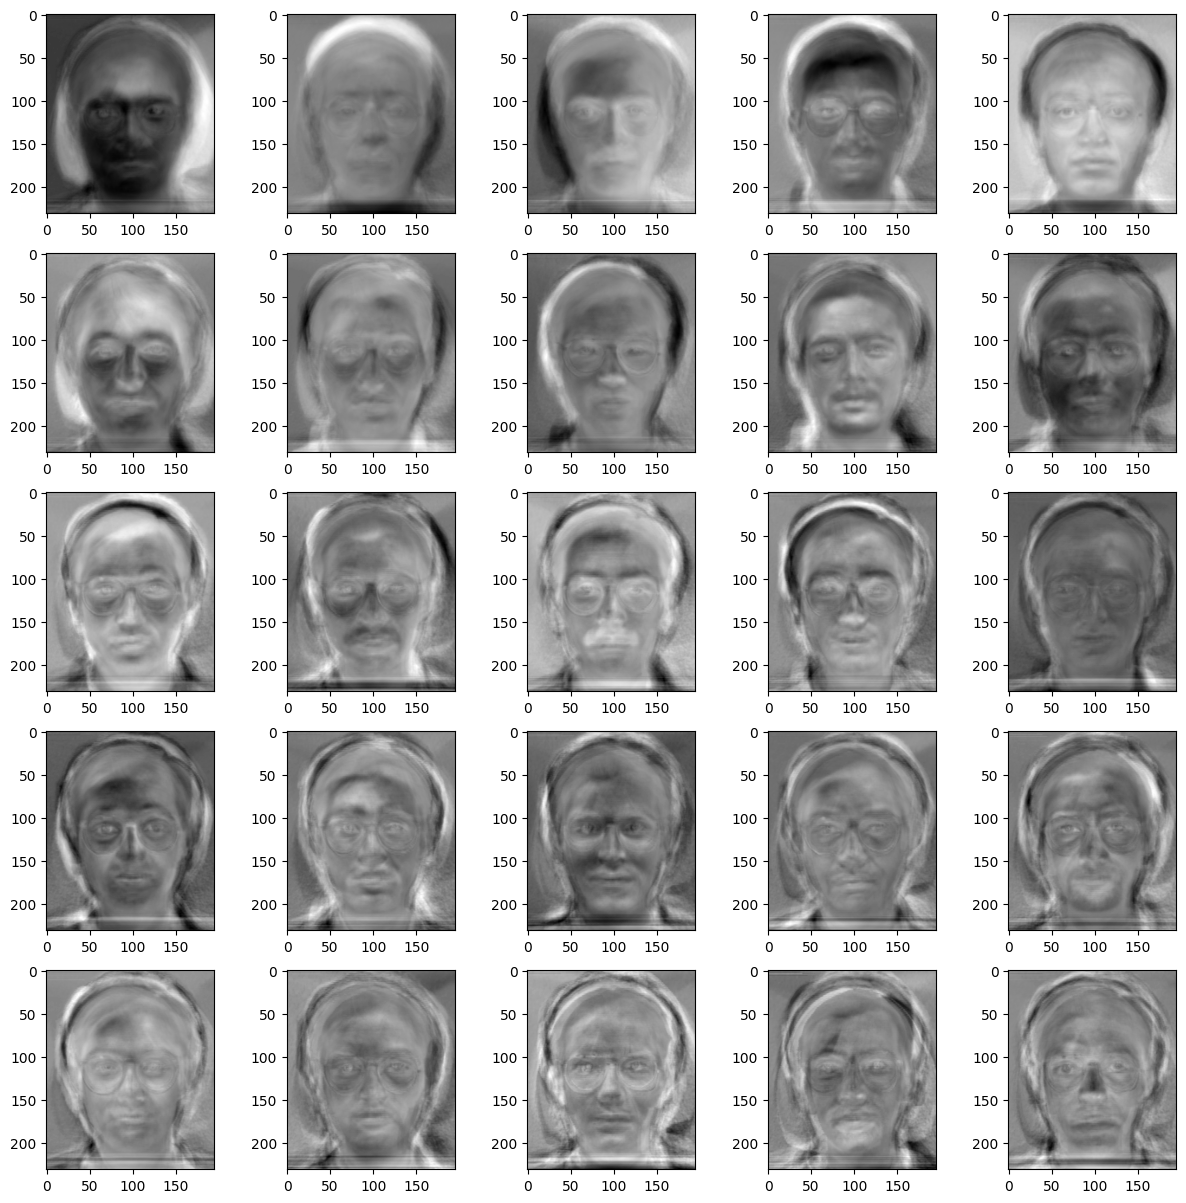

In [60]:
dir = "/Users/cindychen/Documents/ML_HW07/Yale_Face_Database/Training"
H , W = 231 , 195
x_train , y_train = read_file(dir , H , W)

value , vector , x_mean = PCA(x_train)
show_eigenface(vector , 25 , H , W)

From the result of the eigenfaces, we can see that it almost capture the facial features of the images and the contour of different faces. We know that lighter regions correspond to higher variation, where darker regions correspond to little to no variation. Since that PCA focuses on the maximum variance, the output of the eigenfaces is not so bad that we can still recognize these are human faces.

### PCA reconstructed faces

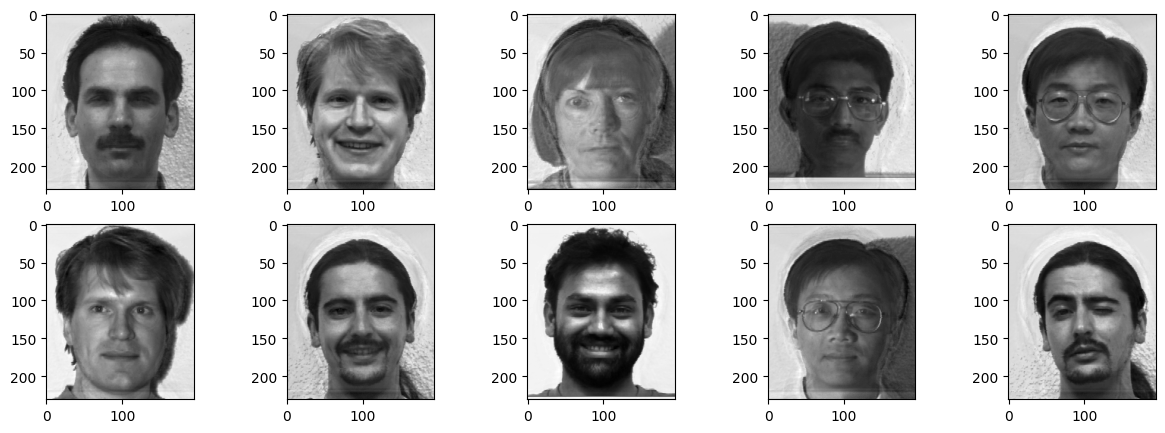

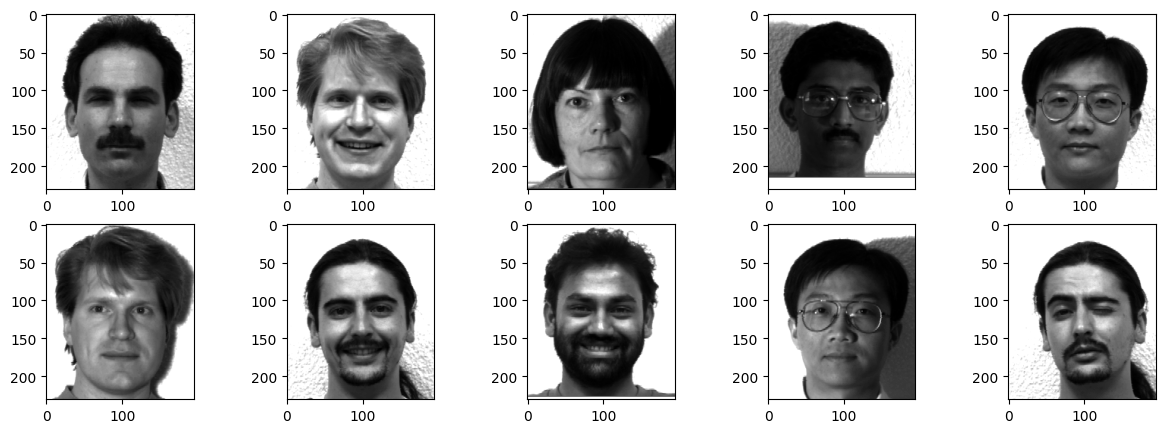

In [8]:
## projecting the vector into lower dimension
vec = vector.T@(x_train - x_mean)
## then projecting back to real space
recon = vector@vec + x_mean
reconstructed_faces(x_train , recon , 10 , H , W)

For the reconstructed faces, the result also turns out good.

### LDA fisherfaces

Different from PCA method, for LDA analysis we have to compute the within-class scatter and between-class scatter for computing eigenvalues and eigenvectors.
$$S_{within} = S_w = \sum_{i=1}^c\sum_{x_j \in X_c}(x_j - \mu_i)(x_j - \mu_i)^T$$
$$S_{between} = S_b = \sum_{i=1}^c N_i(\mu_i - \mu)(\mu_i - \mu)^T$$
where $\mu$ is the total mean of all the image, and $\mu_i$ is the mean of different class. There are 15 different people so c equals to 15, and in the training dataset each person has 9 different pictures $N_i$ = 9.

We can obtain the eigenvalues and eigenvectors by solving the equation of $S_w^{-1}S_bv_i = \lambda_i v_i$.

In [57]:
def LDA(data , label):
    x_mean = data.mean(axis = 1).reshape(-1,1)

    ## compute within-class classes means
    class_mean = np.zeros((data.shape[0] , 15) , dtype = np.float32)
    for i in range(15):
        idx = np.argwhere(label == i).reshape(-1)
        class_mean[:,i] = np.mean(data[:,idx] , axis = 1)     

    S_w = np.zeros((data.shape[0] , data.shape[0]) , dtype = np.float32)
    for i in range(data.shape[1]):
        diff = data[:,i].reshape(-1,1) - class_mean[:,label[i]].reshape(-1,1)
        S_w += diff@diff.T

    ## compute between-class means
    S_b = np.zeros((data.shape[0], data.shape[0]) , dtype = np.float32)
    for i in range(15):
        diff = class_mean[:,i].reshape(-1,1) - x_mean
        S_b += 9*diff@diff.T

    ## compute eigenvalue and eigenvector from within-class scatter and between-class scatter 
    eigenvalue , eigenvector = np.linalg.eig(np.linalg.inv(S_w)@S_b)

    ## sort the eigenvalue from largest to smallest
    sort_idx = np.argsort(eigenvalue)[::-1]
    eigenvalue = eigenvalue[sort_idx].real
    eigenvector = eigenvector[:,sort_idx].real
    norm = np.linalg.norm(eigenvector , axis = 0)
    eigenvector = eigenvector / norm

    return eigenvalue , eigenvector 

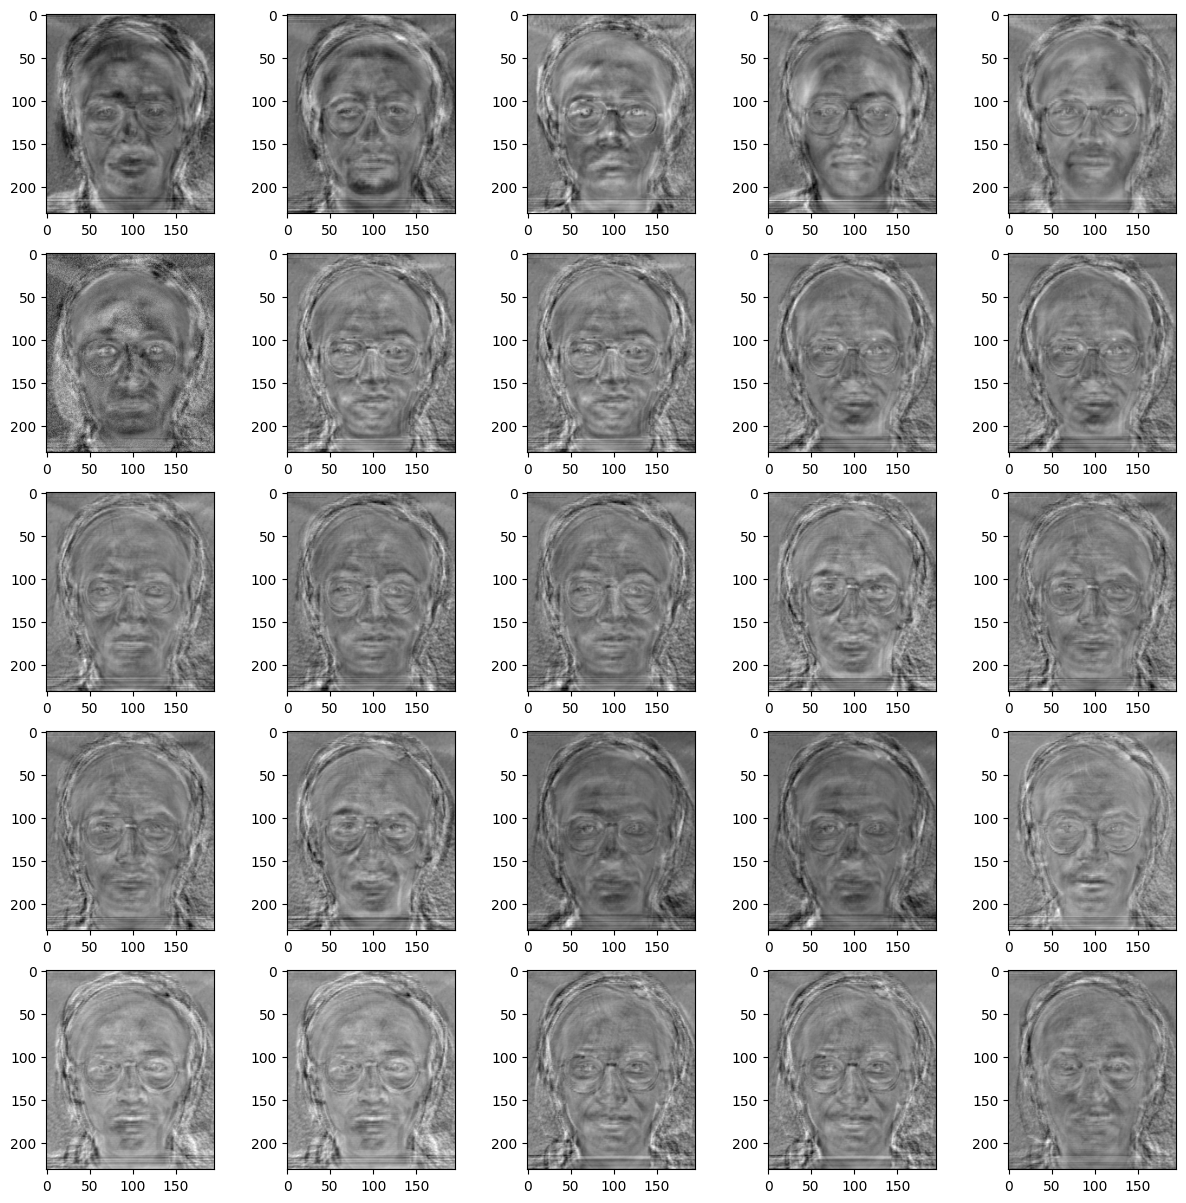

In [58]:
value , vector , X_mean = PCA(x_train)
vec = vector.T@(x_train - X_mean)

value_lda , vector_lda = LDA(vec, y_train)
vec_lda = vector@vector_lda

show_eigenface(vec_lda , 25 , H , W)

Using PCA method to reduce the dimension of images into 135 dimensions first for easy computation. And then use LDA to show the first 25 fisherfaces.

Since LDA analysis is more focus on the between classes and within classes different, the top 25 fisherfaces can only capture the contour of a human face. The facial features of the top 25 fisherfaces are not so clearly to be classify from each others.

### LDA reconstructed faces

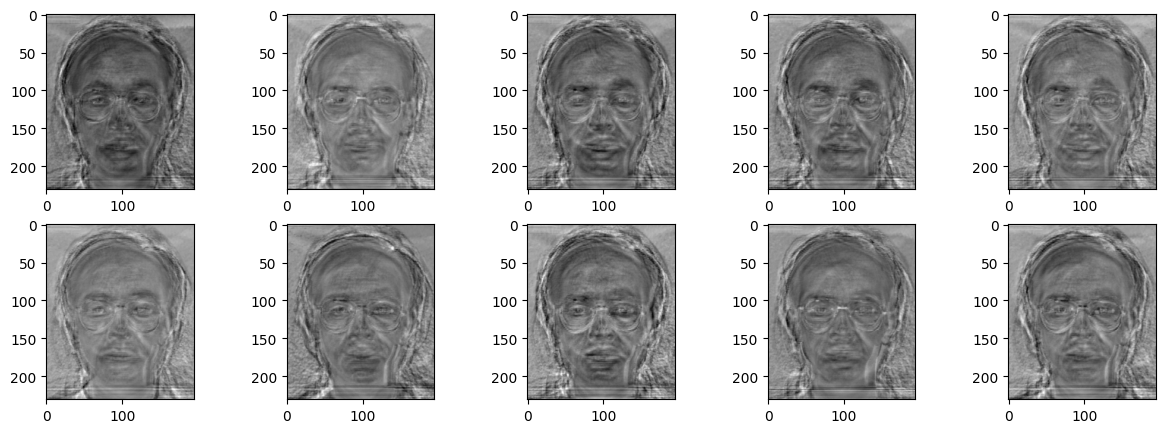

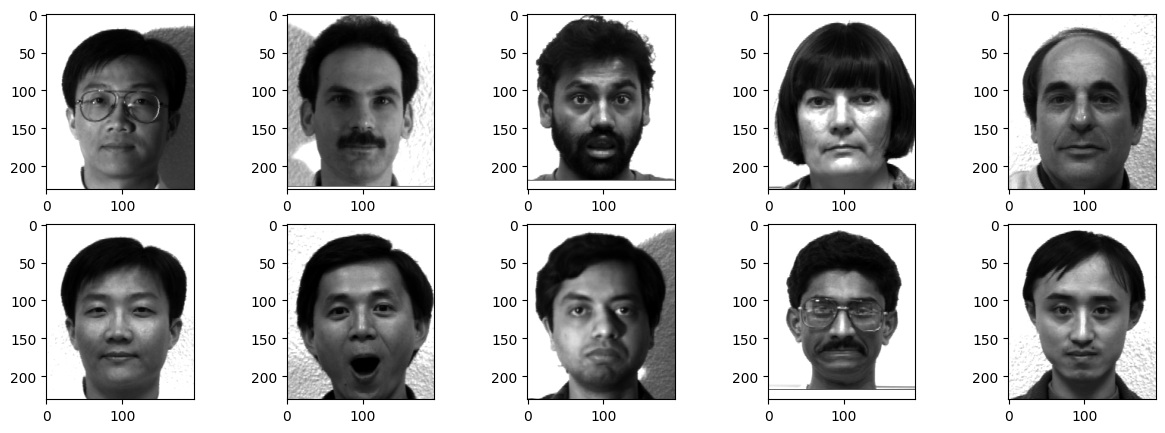

In [59]:
vec_trans = vec_lda.T@x_train 
recon_lda = vec_lda@vec_trans + X_mean
reconstructed_faces(x_train , recon_lda , 10 , H , W)

For the reconstructed result, the LDA analysis also give a bad result different from the PCA method.

### Part II

### Face recognition without kernel

In [176]:
def classification(x_test , y_test , x_train , y_train , k):
    predict = np.zeros(len(y_test))
    for i in range(y_test.shape[0]):
        dist = np.zeros(x_train.shape[1])
        for j in range(x_train.shape[1]):
            dist[j] = np.sum(np.square(x_test[:,i] - x_train[:,j]))
        sort_idx = np.argsort(dist)
        n_neighbor = y_train[sort_idx[:k]]
        neighbor , count = np.unique(n_neighbor , return_counts = True)
        predict[i] = neighbor[np.argsort(-count)[0]]
    
    acc = np.sum(predict == y_test) / len(y_test)
    print("K:{} , accuracy = {:3f}".format(k , acc))

    return predict

### Face recognition for pca method

In [183]:
dir_test = "/Users/cindychen/Documents/ML_HW07/Yale_Face_Database/Testing"
H , W = 231 , 195
x_test , y_test = read_file(dir_test , H , W)

value , vector , x_mean = PCA(x_train)

## turn the test dataset into low dimension
z_test = vector.T@(x_test - x_mean)
x_proj = vector.T@(x_train - x_mean)

for i in range(1,16,2):
    predict = classification(z_test , y_test , x_proj , y_train , i)

K:1 , accuracy = 0.866667
K:3 , accuracy = 0.833333
K:5 , accuracy = 0.866667
K:7 , accuracy = 0.866667
K:9 , accuracy = 0.766667
K:11 , accuracy = 0.866667
K:13 , accuracy = 0.933333
K:15 , accuracy = 0.833333


From the result, we can see that when k = 13 we have the highest accuracy.

### Face recognition for lda method

In [181]:
value , vector , X_mean = PCA(x_train)
vec = vector.T@(x_train - X_mean)

value_lda , vector_lda = LDA(vec, y_train)
vec_lda = vector@vector_lda
vec_trans = vec_lda.T@x_train 

## turn the test dataset into low dimension
z_test = vec_lda.T@(x_test - X_mean)

for i in range(1,16,2):
    predict = classification(z_test , y_test , vec_trans , y_train , i)

K:1 , accuracy = 0.266667
K:3 , accuracy = 0.133333
K:5 , accuracy = 0.600000
K:7 , accuracy = 0.800000
K:9 , accuracy = 0.766667
K:11 , accuracy = 0.733333
K:13 , accuracy = 0.766667
K:15 , accuracy = 0.833333


From the result, we can see that when k = 15 we have the highest accuracy.

### Part III

### Face recognition with kernel

In [215]:
def linearkernel(x):
    return x.T@x

def rbfkernel(x , gamma):
    return np.exp(-gamma * distance.cdist(x , x , "sqeuclidean"))

In [245]:
def kernelPCA(data , dims , type):
    if type == "linear":
        kernel = linearkernel(data)
    else:
        kernel = rbfkernel(data , 1e-4)

    n = kernel.shape[0]
    one = np.ones((n, n), dtype=np.float64) / n
    kernel = kernel - one @ kernel - kernel @ one + one @ kernel @ one
    eigen_val, eigen_vec = np.linalg.eigh(kernel)

    for i in range(eigen_vec.shape[1]):
        eigen_vec[:, i] = eigen_vec[:, i] / np.linalg.norm(eigen_vec[:, i])

    idx = np.argsort(eigen_val)[::-1]
    W = eigen_vec[:, idx][: , :].real
    
    return kernel @ W.T

In [246]:
dir = "/Users/cindychen/Documents/ML_HW07/Yale_Face_Database/Training"
dir_test = "/Users/cindychen/Documents/ML_HW07/Yale_Face_Database/Testing"
H , W = 50 , 50
x_train , y_train = read_file(dir , H , W)
x_test , y_test = read_file(dir_test , H , W)

data = np.hstack((x_train, x_test))

new_coor = kernelPCA(data , 25 , "linear")
new_train = new_coor[:, :len(y_train)]
new_test = new_coor[:,len(y_train):]

In [253]:
preidct = classification(new_test, y_test, new_train, y_train, 5)

K:5 , accuracy = 0.066667


## t-SNE

In [254]:
import sys, os
import numpy as np
import seaborn as sns
import scipy.spatial.distance
import matplotlib.pyplot as plt

### Part I

### t-SNE and symmetric SNE

### SNE (Symmetric-SNE)

SNE works as dimensionality reduction by converting the high-dimensional euclidean distances into conditional probability that represents similarities. So, we project high-dimensional data into low-dimensional data which look like the cost function of KL divergence.
$$C = \sum_i KL(P_i || Q_i) = \sum_i \sum_j p_{j|i} log\frac{p_{j|i}}{q_{j|i}}$$
We want the value of KL divergence to be as small as possible, therefore we can get high similarities in low dimensionality space. The formula of $p_{ij}$ and $q_{ij}$ is shown below.
$$p_{ij} = \frac{exp(-||x_i - x_j||^2/(x\sigma^2))}{\sum_{k\neq l}exp(-||x_l - x_k||^2/(x\sigma^2))}$$
$$q_{ij} = \frac{exp(-||y_i - y_j||^2)}{\sum_{k\neq l}exp(-||y_l - y_k||^2)}$$

### t-SNE (t-Distributed SNE)

Different from symmetric SNE, t-SNE using student's t distribution probability function in low dimensionality space. 
$$p_{ij} = \frac{exp(-||x_i - x_j||^2/(x\sigma^2))}{\sum_{k\neq l}exp(-||x_l - x_k||^2/(x\sigma^2))}$$
$$q_{ij} = \frac{(1+||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1 + ||y_i - y_j||^2)^{-1}}$$

In [ ]:
for iter in range(max_iter):
    # Compute pairwise affinities
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)
    num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
    num[range(n), range(n)] = 0.
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)

    # Compute gradient
    PQ = P - Q
    for i in range(n):
        dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

From the reference code, we can see that it uses conditional probability on low dimensional space q. The formula using t-distribution formula to achieve the conditional probability function.
$$q_{ij} = \frac{(1+||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1 + ||y_i - y_j||^2)^{-1}}$$
And for computing the gradient in t-SNE we use the formula down below.
$$\frac{\delta C}{\delta y_i} = 4\sum_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$$

Now we can change the code to symmetric SNE.

In [ ]:
for iter in range(max_iter):
    # Compute pairwise affinities
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)
    num = np.exp(-1.*np.add(np.add(num , sum_Y).T , sum_Y))

    num[range(n), range(n)] = 0.
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)

    # Compute gradient
    PQ = P - Q
    for i in range(n):
        dY[i, :] = np.dot(PQ[i , :] , Y[i,:] - Y)

That formula using an exponent component with refers to the Gaussian or normal distribution formula to achieve the conditional probability function.
$$q_{ij} = \frac{exp(-||y_i - y_j||^2)}{\sum_{k\neq l}exp(-||y_l - y_k||^2)}$$
And for computing the gradient in SNE we use the formula down below.
$$\frac{\delta C}{\delta y_i} = 2\sum_j (p_{ij} - q_{ij})(y_i - y_j)$$

### Part II

In [309]:
def plotResult(Y, labels, idx, interval, method, perplexity):
    plt.clf()
    scatter = plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
    plt.legend(*scatter.legend_elements(), loc='lower left', title='Digit')
    plt.title(f'{method}, perplexity: {perplexity}, iteration: {idx}')
    plt.tight_layout()
    if interval:
        plt.savefig(f'{method}_{perplexity}_{idx // interval}.png')
    else:
        plt.savefig(f'{method}_{perplexity}_{idx}.png')

In [310]:
def Hbeta(D=np.array([]), beta=1.0):
    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

def x2p(X, tol, perplexity):
    print('Computing pairwise distances...')
    (n, d) = X.shape
    D = distance.cdist(X, X, 'sqeuclidean')
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        if i % 500 == 0:
            print(f'Computing P-values for point {i} of {n}...')
        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
    print(f'Mean value of sigma: {np.mean(np.sqrt(1 / beta))}')
    return P

In [294]:
def pca(X, dims):
    print('Preprocessing the data using PCA...')
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, axis=0), (n, 1))
    (eigen_val, eigen_vec) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, eigen_vec[:, 0:dims])
    return Y

In [311]:
def sne(X, dims, init_dims, perplexity, labels, method, interval):
    X = pca(X, init_dims).real
    (n, d) = X.shape
    Y = np.random.randn(n, dims)
    dY = np.zeros((n, dims))
    iY = np.zeros((n, dims))
    gains = np.ones((n, dims))
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4                   # early exaggeration
    P = np.maximum(P, 1e-12)

    for itr in range(max_iter):
        # Compute pairwise affinities
        if method == 'tsne':
            num = 1 / (1 + scipy.spatial.distance.cdist(Y, Y, 'sqeuclidean'))
        else:
            num = np.exp(-1 * scipy.spatial.distance.cdist(Y, Y, 'sqeuclidean'))
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            if method == 'tsne':
                dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (dims, 1)).T * (Y[i, :] - Y), axis=0)
            else:
                dY[i, :] = np.sum(np.tile(PQ[:, i], (dims, 1)).T * (Y[i, :] - Y), axis=0)

        # Perform the update
        if itr < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if itr % interval == 0:
            plotResult(Y, labels, itr, interval, method, perplexity)

        # Compute current value of cost function
        if (itr + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f'Iteration {itr + 1}: error is {C}')

        # Stop lying about P-values
        if itr == 100:
            P = P / 4

    return Y, P, Q
   

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.386596621341598
Iteration 10: error is 23.67132573898476
Iteration 20: error is 21.006746482086506
Iteration 30: error is 17.928447707923528
Iteration 40: error is 16.849853702899942
Iteration 50: error is 16.517391978695585
Iteration 60: error is 16.346203264091578
Iteration 70: error is 16.201771292663675
Iteration 80: error is 16.114435558665967
Iteration 90: error is 16.119297818135333
Iteration 100: error is 16.07352492632593
Iteration 110: error is 2.359894221382359
Iteration 120: error is 2.1024957559192043
Iteration 130: error is 1.911612786346212
Iteration 140: error is 1.76798679230404
Iteration 150: error is 1.6581414949190356
Iteration 160: error is 1.5725964471737663

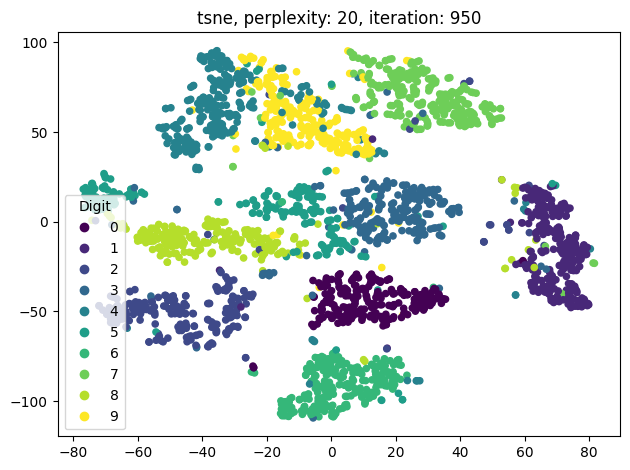

In [305]:
X = np.loadtxt("/Users/cindychen/Documents/tsne_python/mnist2500_X.txt")
labels = np.loadtxt("/Users/cindychen/Documents/tsne_python/mnist2500_labels.txt")
Y, P, Q = sne(X, 2, 50, 20, labels, "tsne", 50)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.386596621341598
Iteration 10: error is 23.542497163274312
Iteration 20: error is 19.228628997145915
Iteration 30: error is 17.850320450208855
Iteration 40: error is 17.292568389572416
Iteration 50: error is 17.077153909929155
Iteration 60: error is 16.882856075529595
Iteration 70: error is 16.835364265801743
Iteration 80: error is 16.830541683416236
Iteration 90: error is 16.819417711893397
Iteration 100: error is 16.812856968083434
Iteration 110: error is 2.2370328917818503
Iteration 120: error is 2.0844610699864483
Iteration 130: error is 2.084956799958217
Iteration 140: error is 2.098392461892874
Iteration 150: error is 2.103495697042625
Iteration 160: error is 2.1005862882233

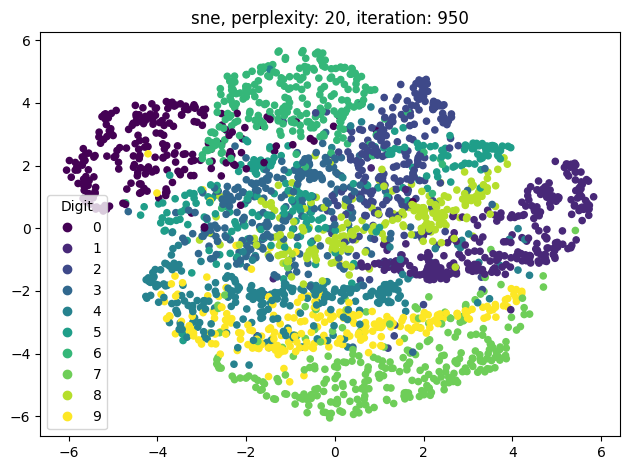

In [306]:
Y_sne, P_sne, Q_sne = sne(X, 2, 50, 20, labels, "sne", 50)

From the result, we can see that the scatter plot of t-SNE is not so crowded, every group is separated from each other.

### Part III

In [298]:
def plotHighDLowD(P, Q, method, perplexity):
    pal = sns.light_palette('blue', as_cmap=True)
    plt.clf()
    plt.title('High-D Similarity')
    plt.imshow(P, cmap=pal)
    plt.savefig(f'./{method}_{perplexity}/High_D.png')

    plt.clf()
    plt.title('Low-D Similarity')
    plt.imshow(Q, cmap=pal)
    plt.savefig(f'./{method}_{perplexity}/Low_D.png')

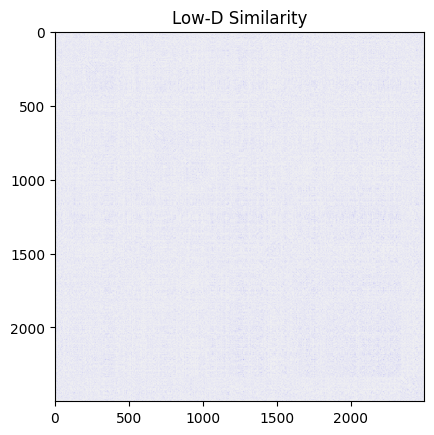

In [302]:
plotHighDLowD(P_sne, Q_sne, 'sne', 20)

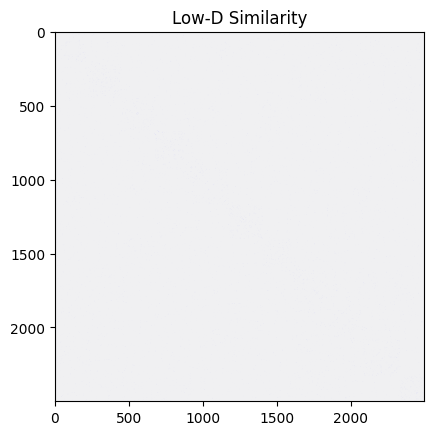

In [301]:
plotHighDLowD(P, Q, 'tsne', 20)

### Part IIII

### Play with different perplexity

In [415]:
image1 = Image.open("/Users/cindychen/Documents/ML_HW7_310657012_陳芃辰/sne_5_1.png")
image2 = Image.open("/Users/cindychen/Documents/ML_HW7_310657012_陳芃辰/sne_20_1.png")
image3 = Image.open("/Users/cindychen/Documents/ML_HW7_310657012_陳芃辰/sne_30_1.png")
image4 = Image.open("/Users/cindychen/Documents/ML_HW7_310657012_陳芃辰/sne_40_1.png")
image5 = Image.open("/Users/cindychen/Documents/ML_HW7_310657012_陳芃辰/sne_100_1.png")
file = [image1 , image2 , image3 , image4 , image5]

### Symmetric SNE 

From the result of different perplexity, it shows that there is no different between each plots.

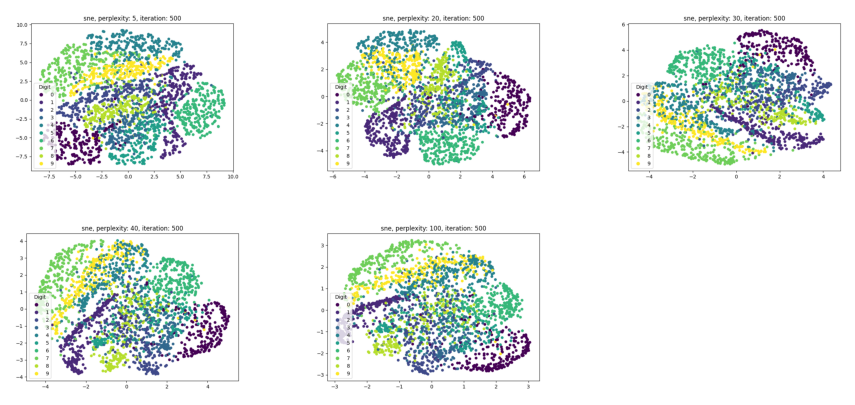

In [416]:
fig = plt.figure(figsize=(11, 5))
for i in range(len(file)):
    fig.add_subplot(2, 3, i+1)
    plt.imshow(file[i])
    plt.axis('off')

In [413]:
image1_t = Image.open("/Users/cindychen/Documents/ML_HW7_310657012_陳芃辰/tsne_5_1.png")
image2_t = Image.open("/Users/cindychen/Documents/ML_HW7_310657012_陳芃辰/tsne_20_1.png")
image3_t = Image.open("/Users/cindychen/Documents/ML_HW7_310657012_陳芃辰/tsne_30_1.png")
image4_t = Image.open("/Users/cindychen/Documents/ML_HW7_310657012_陳芃辰/tsne_40_1.png")
image5_t = Image.open("/Users/cindychen/Documents/ML_HW7_310657012_陳芃辰/tsne_100_1.png")
file_t = [image1_t , image2_t , image3_t , image4_t , image5_t]

### t-SNE

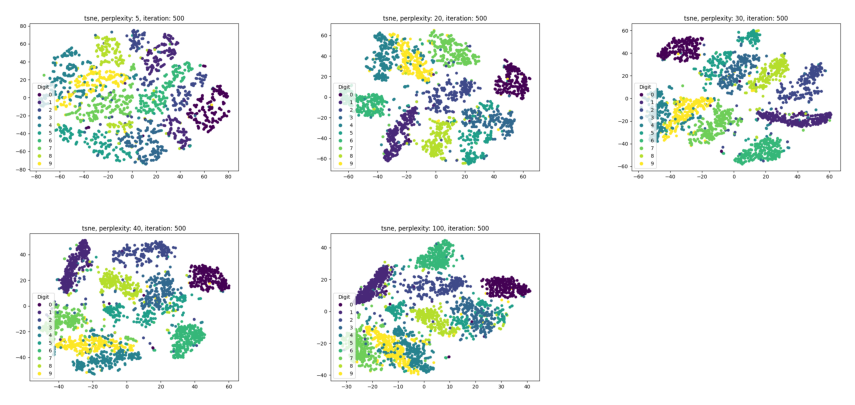

In [414]:
fig = plt.figure(figsize=(11, 5))
for i in range(len(file_t)):
    fig.add_subplot(2, 3, i+1)
    plt.imshow(file_t[i])
    plt.axis('off')